In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
import os
os.listdir("/content/drive/MyDrive")

['Colab Notebooks', 'AI_Image_Detection_Data']

In [8]:
DATA_ROOT = "/content/drive/MyDrive/AI_Image_Detection_Data"
CSV_PATH = f"{DATA_ROOT}/index/dataset_index.csv"

In [9]:
print(os.listdir(DATA_ROOT))
print(os.listdir(f"{DATA_ROOT}/index"))

['index', 'genimage', 'coco', 'checkpoints']
['dataset_index.csv', 'annotations_trainval2017.zip', 'annotations']


In [10]:
import os
print(os.path.exists(CSV_PATH))

True


In [11]:
import pandas as pd

df = pd.read_csv(CSV_PATH)

print("Total rows:", len(df))
print("\nSplit counts:\n", df["split"].value_counts())
print("\nLabel counts:\n", df["label"].value_counts())

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)

print("\nTrain rows:", len(train_df))
print("Val rows  :", len(val_df))

Total rows: 25000

Split counts:
 split
train    20000
val       5000
Name: count, dtype: int64

Label counts:
 label
0    15000
1    10000
Name: count, dtype: int64

Train rows: 20000
Val rows  : 5000


In [12]:
from torchvision import transforms

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # ✅ resize
    transforms.RandomHorizontalFlip(p=0.5),     # ✅ augmentation (train only)
    transforms.RandomRotation(10),              # ✅ augmentation (train only)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),  # ✅ normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # ✅ resize
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),  # ✅ normalization
])

print("✅ Transforms created.")

✅ Transforms created.


In [14]:
# duplicates across entire dataset
dup_paths = df[df["filepath"].duplicated(keep=False)].sort_values("filepath")
print("Duplicate filepaths:", len(dup_paths))

# duplicates across splits (same filepath in multiple splits)
split_counts = df.groupby("filepath")["split"].nunique()
leak_paths = split_counts[split_counts > 1]
print("Filepaths appearing in more than one split:", len(leak_paths))

Duplicate filepaths: 0
Filepaths appearing in more than one split: 0


In [15]:
import time
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class ImageIndexDataset(Dataset):
    def __init__(self, df, transform=None, retries=3, sleep=0.2):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.retries = retries
        self.sleep = sleep

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        label = int(row["label"])

        last_err = None
        for _ in range(self.retries):
            try:
                img = Image.open(img_path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                return img, label
            except Exception as e:
                last_err = e
                time.sleep(self.sleep)

        raise RuntimeError(f"Could not read: {img_path}\nLast error: {last_err}")

BATCH_SIZE = 32
train_loader = DataLoader(ImageIndexDataset(train_df, train_transform),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0)

val_loader = DataLoader(ImageIndexDataset(val_df, val_transform),
                        batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0)

x, y = next(iter(train_loader))
print("✅ Batch loaded!")
print("x shape:", x.shape)   # should be [32, 3, 224, 224]
print("y unique labels:", torch.unique(y))

✅ Batch loaded!
x shape: torch.Size([32, 3, 224, 224])
y unique labels: tensor([0, 1])


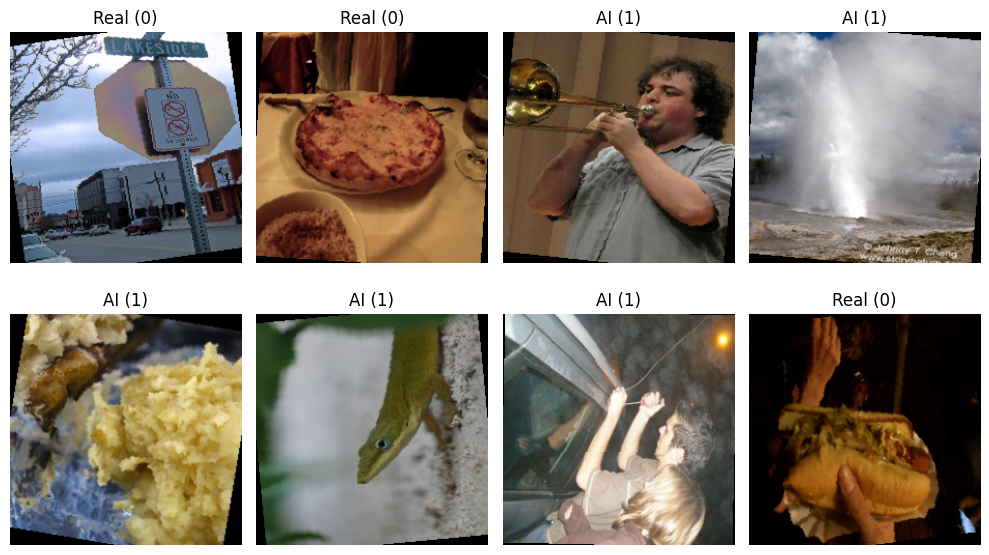

In [16]:
import matplotlib.pyplot as plt
import torch

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def denormalize(t):
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std = torch.tensor(IMAGENET_STD).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 6))
for i in range(8):
    img = denormalize(images[i]).permute(1,2,0)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title("AI (1)" if labels[i].item()==1 else "Real (0)")
    plt.axis("off")
plt.tight_layout()
plt.show()